# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Decision Tree, and will then apply a Decision Tree classsifier on the MNIST hand written digits dataset that we already saw.


## 1. Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer
Initial sample entropy is $-\frac{2}{4}*log(\frac{2}{4}) - \frac{2}{4}*log(\frac{2}{4}) = 1$

Possible splits are:
* By feature #0: $\frac{3}{4}(-\frac{2}{3}*log(\frac{2}{3})) + \frac{1}{4}(-\frac{1}{3}*log(\frac{1}{3})) = 0.69$
* Other features would divide the labels 1:1, in both children, making the entropy 1.

So #0 is the best first split. Removing feature #0 and the last sample (which becomes a leaf), the next split would be determined on :

$$
\begin{aligned}
((1, 1), 1)\\
((0, 0), 1)\\
((1, 0), 0)
\end{aligned}
$$

Splitting by either feature would result in a single-sample leaf and a 1:1 node, with entropy of 1. Since this is the last level of the tree, 1/4 of the training samples are always miscalssified. 

A better tree would look like so:

    root
        #1 == 0:
            #2 == 0:
                Sample #1
            #2 != 0:
                Sample #3

        #1 != 0:
            #2 == 0:
                Sample #2
            #2 != 0:
                Sample #0

That way every sample is in a separate leaf and the entorpy is 0.


## 2. Implementing Decision Tree From Scratch
In this exercise you will need to implement a simple version of Decision Tree from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes).

* Compelete the skeleton class below
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `min_leaf` is the minimal number of samples in each leaf node
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(nlgn)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* To check your decision tree implementation, use the boston dataset (`from sklearn.datasets import load_boston`) split the data set into train and test using (`from sklearn.model_selection import train_test_split`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
    for min_leaf in [1,5,10,100]:
      dt = DecisionTree(X, y, n, sz, min_leaf)
      mse = # mean square error over test set
      print("min_leaf:{0} --- oob mse: {1}".format(min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = dt.predict(X_train)  # forest is the chosen model
  plt.scatter(y_hat, y_test)
  ```

In [1]:
# Node class to represent the tree
class Node():

  def __init__(self, attribute=None, threshold=None, left=None, right=None, tag_if_leaf=None):
    self.attribute = attribute
    self.threshold = threshold
    self.left = left
    self.right = right
    self.tag_if_leaf = tag_if_leaf
  
  def predict(self, xi):
    if self.tag_if_leaf is not None:
      return self.tag_if_leaf

    if xi[self.attribute] > self.threshold:
      return self.right.predict(xi)
    else:
      return self.left.predict(xi)

  def __repr__(self) -> str:
    return f'leaf tag: {self.tag_if_leaf}' if self.tag_if_leaf is not None else f'#{self.attribute} > {self.threshold}?'


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import math
import sys 

class DecisionTree():

  def __init__(self, X, y, min_leaf=1):
    self.min_leaf = min_leaf
    self.X = pd.DataFrame(X)
    self.y = pd.Series(y)

    s = X.argsort(axis=0)
    self._sorted_X = pd.DataFrame(np.take_along_axis(X, s, axis=0))
    self._sorted_y = pd.DataFrame(y[s])

    self._decisions = self._fit(self.X.index, self.X.columns, X.mean())

  def _fit(self, examples, attributes, default):
    
    if examples.empty:
      return Node(tag_if_leaf=default)
    elif len(examples) < self.min_leaf or not len(attributes):
      return Node(tag_if_leaf=self.y.loc[examples].mean())

    try:
      best_attribute, best_thresh = self.find_best_split(attributes, examples) # finds the attribute to split by and the value to use for it
    except ValueError:
      # No good split
      return Node(tag_if_leaf=self.y.loc[examples].mean())
    
    other_attributes = attributes.drop(best_attribute)

    subsample = self.X.loc[examples, best_attribute]      
    subsample_mean = self.y.loc[examples].mean()
    
    side_mask = np.greater(subsample, best_thresh)
    right_index = subsample[side_mask].index
    left_index = subsample[~side_mask].index

    left_node = self._fit(left_index, other_attributes, subsample_mean)
    right_node = self._fit(right_index, other_attributes, subsample_mean)

    return Node(best_attribute, best_thresh, left_node, right_node)
    

  def predict(self, X):
    return np.array([self._decisions.predict(xi) for xi in X])


  def find_possible_splits(self, attributes, examples):
    
    sorted_sample_X = self._sorted_X.loc[examples, attributes].values
    sorted_sample_y = self._sorted_y.loc[examples, attributes].values

    borders = np.nonzero(np.diff(sorted_sample_y, axis=0))
    means = sorted_sample_X[:-1] + np.diff(sorted_sample_X, axis=0)/2
    border_means = means[borders]

    return attributes.values[borders[1]], border_means #borders[1] is the attributes and the mean is their split values


  def calculate_split_variance(self, attr, thresh, examples):
      mask = self.X.loc[examples, attr].values > thresh

      if not mask.any() or mask.all():
        return np.inf

      sample_labels = self.y.loc[examples].values
      
      pro_weight = mask.mean()
      foe_weight = 1 - pro_weight
      
      pro_var = sample_labels.var(where=mask) * pro_weight
      foe_var = sample_labels.var(where=~mask) * foe_weight

      return pro_var + foe_var 

  def find_best_split(self, attributes, examples):

      attr, thresh = self.find_possible_splits(attributes, examples)
      
      split_scores = {(a,t): self.calculate_split_variance(a, t, examples) for a,t in zip(attr, thresh)}

      best_split = min(split_scores, key=split_scores.get)
      
      if np.isinf(split_scores[best_split]):
        raise ValueError
      
      return best_split


In [3]:
import numpy as np
class DecisionTree():

  def __init__(self, X, y, min_leaf=1):
    
    self.min_leaf = min_leaf

    self._decisions = self._grow(X, y, np.arange(X.shape[1]), y.mean())

  def _grow(self, X, y, attributes, default):
    
    n = X.shape[0]
    y_mean = y.mean()

    if not len(attributes):
      return Node(tag_if_leaf=y_mean)
    elif n == 0:
      return Node(tag_if_leaf=default)
    elif n < self.min_leaf or n==1:
      return Node(tag_if_leaf=y_mean)

    try:
      best_attribute, best_thresh = self.find_best_split(X, y, attributes) # finds the attribute to split by and the value to use for it
    except ValueError:
      return Node(tag_if_leaf=y_mean)
    
    other_attributes = [a for a in attributes if a != best_attribute]

    side_mask = X[:, best_attribute] > best_thresh

    left_node = self._grow(X[~side_mask], y[~side_mask], other_attributes, y_mean)
    right_node = self._grow(X[side_mask], y[side_mask], other_attributes, y_mean)

    return Node(best_attribute, best_thresh, left_node, right_node)
    

  def predict(self, X):
    return np.array([self._decisions.predict(xi) for xi in X])


  def find_best_split(self, X, y, attributes):

      attr, thresholds = self.find_possible_splits(X, y, attributes)
      
      split_scores = {(c,t): self.calculate_split_variance(c, t, X, y) \
                        for c, t in zip(attr, thresholds)}

      best_split = min(split_scores, key=split_scores.get)

      if np.isinf(split_scores[best_split]):
        raise ValueError
            
      return best_split

  def find_possible_splits(self, X, y, attributes,):
    
    s = X.argsort(axis=0)
    sorted_X = np.take_along_axis(X, s, axis=0)
    sorted_y = y[s]

    borders = np.nonzero(np.diff(sorted_y, axis=0))
    means = sorted_X[:-1] + np.diff(sorted_X, axis=0)/2
    border_means = means[borders]

    return borders[1], border_means #borders[1] is the attributes and the mean is their split values

  def calculate_split_variance(self, attr, thresh, X, y):
      mask = X[:, attr] > thresh

      if not mask.any() or mask.all():
        return np.inf

      pro_weight = mask.mean()
      foe_weight = 1 - pro_weight
      
      pro_var = y.var(where=mask) * pro_weight
      foe_var = y.var(where=~mask) * foe_weight

      return pro_var + foe_var 

In [12]:
# setup
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(*load_boston(return_X_y=True), random_state=24, shuffle=True, train_size=0.65)

c:\Program Files\Anaconda3\envs\py4dp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housi

In [13]:
best_mse = float('inf')
best_tree = None
for min_leaf in [1,5,10,100]:
    dt = DecisionTree(X_train, y_train, min_leaf)
    mse = mean_squared_error(y_val, dt.predict(X_val))
    if mse < best_mse:
        best_mse = mse
        best_tree = dt
    print(f"min_leaf:{min_leaf} --- oob mse: {mse}")

min_leaf:1 --- oob mse: 26.552247191011233
min_leaf:5 --- oob mse: 22.58829236891386
min_leaf:10 --- oob mse: 22.041567003317137
min_leaf:100 --- oob mse: 25.036863800965918


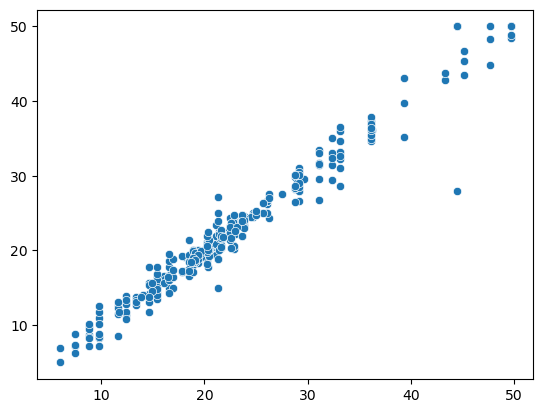

In [14]:
import seaborn as sns

y_hat = best_tree.predict(X_train)
sns.scatterplot(x=y_hat, y=y_train);

## 3. Using Decision Tree for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
  - You can use `sklearn.tree.DecisionTreeClassifier`
- Once you are satisfied with the model parameters, plot the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [7]:
# code and answer go here
from sklearn.tree import DecisionTreeClassifier
from keras.datasets import mnist
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer

PIC_SHAPE = (28,28)
PIC_SIZE = np.multiply(*PIC_SHAPE)
(X_train_val, y_train_val), (X_test, y_test) = mnist.load_data()

X = np.concatenate([X_train_val, X_test])
y = np.concatenate([y_train_val, y_test])

X = X.reshape(-1, PIC_SIZE)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

pipe = make_pipeline(Binarizer(), DecisionTreeClassifier())

if False: # was used for the actual gridsearch
    params = {
                'binarizer__threshold': np.linspace(0, 255, 10),
                'decisiontreeclassifier__min_samples_split': [0.01, 0.001],
                'decisiontreeclassifier__max_features': [28, 56, 84, 112],
                'decisiontreeclassifier__max_depth': np.arange(1, 5) * 28,
                'decisiontreeclassifier__criterion': ['gini','entropy','log_loss'], 
                'decisiontreeclassifier__ccp_alpha': np.linspace(0, 3, 10), 
            }
else: #best params found
        params = {
                'binarizer__threshold': [0],
                'decisiontreeclassifier__min_samples_split': [0.001], 
                'decisiontreeclassifier__max_features': [112], 
                'decisiontreeclassifier__max_depth': [28], 
                'decisiontreeclassifier__criterion': ['entropy'], 
                'decisiontreeclassifier__ccp_alpha': [0],
                'decisiontreeclassifier__min_samples_leaf': [10],

            }

grid = GridSearchCV(pipe, param_grid=params, n_jobs=-1, scoring='balanced_accuracy', cv=5).fit(X_train, y_train)

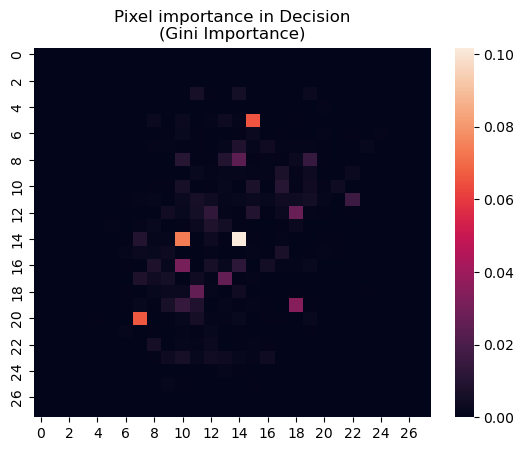

In [8]:
t = grid.best_estimator_.steps[1][1]
sns.heatmap(t.feature_importances_.reshape(PIC_SHAPE)).set(title='Pixel importance in Decision\n(Gini Importance)');

In [9]:
vis = pd.DataFrame({
    'correct': (grid.predict(X_test) == y_test),
    'max_prob': grid.predict_proba(X_test).max(axis=1),
    'highest_prob_class': grid.predict_proba(X_test).argmax(axis=1),
    'actual_class': y_test
    })


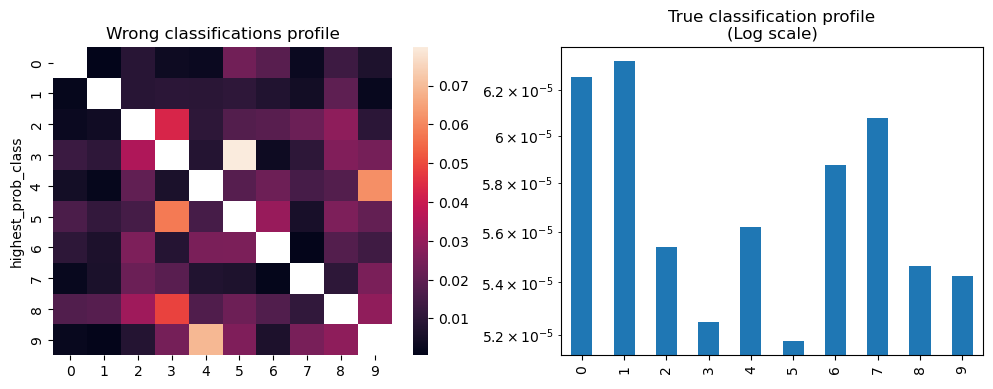

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

prior = vis['actual_class'].value_counts()

plt.subplot(1,2,1)
sns.heatmap(vis[~vis['correct']].groupby(['highest_prob_class', 'actual_class']).size().unstack()/prior).set(title='Wrong classifications profile');

plt.subplot(1,2,2)
(vis.loc[vis['correct'],'actual_class'].value_counts(normalize=True)/prior).plot(kind='bar', log=True).set(title='True classification profile\n(Log scale)');

When looking at the wrong classifications to the left, we can see what numbers we most often mistake for others, 3, for instance, is most often mistaken for either 5 or 8, which makes sense given its shape.
It's interesting to note this plot is not entirely symmetric: we often classify 3 as two, but not the other way around. 

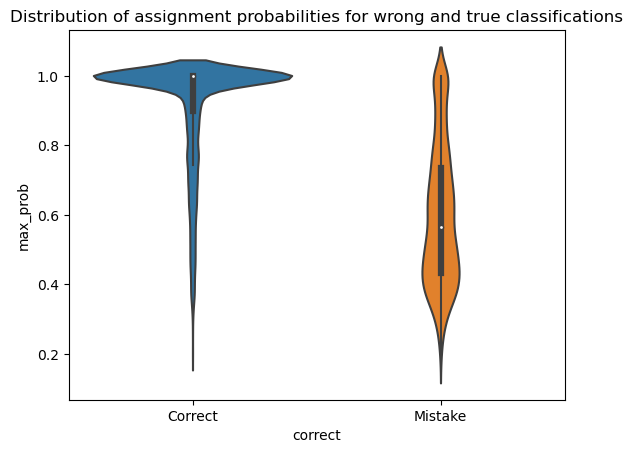

In [11]:
more_vis = vis.copy()
more_vis['correct'] = more_vis['correct'].map({True: 'Correct', False: 'Mistake'})
sns.violinplot(more_vis, y='max_prob', x='correct').set(title='Distribution of assignment probabilities for wrong and true classifications');

From the above plot, it's noticeable that the model is usually a lot less certain about its mistakes than about its successes. The highest class probability it produces has a huge variance (nearly uniform), while classifications it got right usually have $> 0.9$ probabilities. 